<a href="https://colab.research.google.com/github/whiskycasablanca/CLIP_Implementation/blob/encoder_freeze/train0314_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/whiskycasablanca/CLIP_Implementation.git
%cd /content/CLIP_Implementation/

Cloning into 'CLIP_Implementation'...
remote: Enumerating objects: 8240, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 8240 (delta 25), reused 16 (delta 4), pack-reused 8194 (from 1)
Receiving objects: 100% (8240/8240), 1.03 GiB | 17.28 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (8116/8116), done.
/content/CLIP_Implementation


In [4]:
!git checkout encoder_freeze

Branch 'encoder_freeze' set up to track remote branch 'encoder_freeze' from 'origin'.
Switched to a new branch 'encoder_freeze'


In [5]:
import os
import random
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from transformers import DistilBertTokenizer
from models import CLIPModel  # models.py 내의 CLIPModel (forward에 return_logits 옵션 추가)
from dataset import Flickr8kDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
#========================
# 1. Seed 설정 (재현성을 위해)
# ========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ========================
# 2. Device설정
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#
# ========================
# 3. 토크나이저 및 이미지 전처리 정의
# ========================
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711])
])


In [7]:

# ========================
# 4. Dataset 및 DataLoader 생성
# ------------------------
# train split 파일: Flickr_8k.trainImages.txt
train_dataset = Flickr8kDataset(
    img_folder='images',
    caption_file='captions.txt',
    split_file='Flickr_8k.trainImages.txt',  # 분할 파일 경로 지정
    transform=transform,
    tokenizer=tokenizer,
    max_length=40
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# validation split 파일: Flickr_8k.devImages.txt
val_dataset = Flickr8kDataset(
    img_folder='images',
    caption_file='captions.txt',
    split_file='Flickr_8k.devImages.txt',  # 분할 파일 경로 지정
    transform=transform,
    tokenizer=tokenizer,
    max_length=40
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# test split 파일: Flickr_8k.testImages.txt
test_dataset = Flickr8kDataset(
    img_folder='images',
    caption_file='captions.txt',
    split_file='Flickr_8k.testImages.txt',  # 분할 파일 경로 지정
    transform=transform,
    tokenizer=tokenizer,
    max_length=40
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# ========================
# 5. Model 및 옵티마이저 설정
# ========================
model = CLIPModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 초기 러닝 레이트 1e-4 사용
# ReduceLROnPlateau: validation loss가 2epoch동안 개선 안되면 러닝 레이트를 0.5배로 감소시키기
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# 손실 기록용 리스트
train_loss_history = []
val_loss_history = []

# ========================
# 6. Training, Validation 루프
# ========================
num_epochs = 30
best_val_loss = float('inf')
patience_counter = 0  # early stopping을 위한 카운터

for epoch in range(num_epochs):
    # --- Training phase ---
    model.train()
    train_loss = 0.0
    total_train_batches = 0
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    step = 0
    for batch in pbar:
        step += 1
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        inputs = {"image": images, "input_ids": input_ids, "mask": mask}

        loss = model(inputs)  # training 모드에서는 loss만 반환
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_batches += 1

        # 10 스텝마다 현재 Loss 출력
        if step % 10 == 0:
            pbar.set_postfix({"Loss": loss.item()})
    train_loss /= total_train_batches
    train_loss_history.append(train_loss)

    # --- Validation phase ---
    model.eval()
    val_loss = 0.0
    total_val_batches = 0
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            mask = batch["mask"].to(device)
            inputs = {"image": images, "input_ids": input_ids, "mask": mask}

            # return_logits=True로 logits도 함께 반환받음
            loss, logits = model(inputs, return_logits=True)
            val_loss += loss.item()
            total_val_batches += 1

            batch_size = logits.size(0)
            total_samples += batch_size
            labels = torch.arange(batch_size).to(device)
            preds_top1 = logits.argmax(dim=1)
            correct_top1 += (preds_top1 == labels).sum().item()
            top5_preds = logits.topk(5, dim=1)[1]  # shape: [batch_size, 5]
            for i in range(batch_size):
                if labels[i] in top5_preds[i]:
                    correct_top5 += 1

    val_loss /= total_val_batches
    top1_acc = 100.0 * correct_top1 / total_samples
    top5_acc = 100.0 * correct_top5 / total_samples
    val_loss_history.append(val_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Top1: {top1_acc:.2f}% | Val Top5: {top5_acc:.2f}%")

    # 러닝 레이트 스케줄러 적용: 현재 validation 손실을 기준으로 조정
    scheduler.step(val_loss)

    # 모델 체크포인트 저장 (발리데이션 손실이 개선되면)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved.")
        patience_counter = 0  # 개선되었으므로 카운터 리셋
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")

    # 만약 5번 이상 개선이 없으면 학습 조기 종료
    if patience_counter >= 5:
        print("Validation loss did not improve for 5 consecutive epochs. Early stopping triggered.")
        break



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch [1/30]: 100%|██████████| 188/188 [01:33<00:00,  2.00it/s, Loss=2.6]


[Epoch 1/30] Train Loss: 3.3215 | Val Loss: 2.6244 | Val Top1: 22.00% | Val Top5: 62.30%
Best model saved.


Epoch [2/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=2.52]


[Epoch 2/30] Train Loss: 2.4027 | Val Loss: 2.1826 | Val Top1: 33.00% | Val Top5: 74.50%
Best model saved.


Epoch [3/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=1.98]


[Epoch 3/30] Train Loss: 2.0181 | Val Loss: 1.9737 | Val Top1: 39.50% | Val Top5: 82.00%
Best model saved.


Epoch [4/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=1.98]


[Epoch 4/30] Train Loss: 1.7805 | Val Loss: 1.8304 | Val Top1: 42.90% | Val Top5: 82.80%
Best model saved.


Epoch [5/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=1.61]


[Epoch 5/30] Train Loss: 1.6655 | Val Loss: 1.7137 | Val Top1: 46.60% | Val Top5: 86.50%
Best model saved.


Epoch [6/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=1.33]


[Epoch 6/30] Train Loss: 1.5157 | Val Loss: 1.6790 | Val Top1: 47.60% | Val Top5: 86.60%
Best model saved.


Epoch [7/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=1.73]


[Epoch 7/30] Train Loss: 1.4384 | Val Loss: 1.6168 | Val Top1: 49.20% | Val Top5: 88.40%
Best model saved.


Epoch [8/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=1.15]


[Epoch 8/30] Train Loss: 1.3850 | Val Loss: 1.5515 | Val Top1: 51.40% | Val Top5: 89.70%
Best model saved.


Epoch [9/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=1.25]


[Epoch 9/30] Train Loss: 1.2662 | Val Loss: 1.5337 | Val Top1: 52.50% | Val Top5: 89.80%
Best model saved.


Epoch [10/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=0.895]


[Epoch 10/30] Train Loss: 1.2275 | Val Loss: 1.5631 | Val Top1: 51.60% | Val Top5: 89.50%
No improvement for 1 epoch(s).


Epoch [11/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=1.72]


[Epoch 11/30] Train Loss: 1.1642 | Val Loss: 1.5745 | Val Top1: 51.30% | Val Top5: 89.20%
No improvement for 2 epoch(s).


Epoch [12/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=1.16]


[Epoch 12/30] Train Loss: 1.1399 | Val Loss: 1.4831 | Val Top1: 54.30% | Val Top5: 89.70%
Best model saved.


Epoch [13/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.85]


[Epoch 13/30] Train Loss: 1.0816 | Val Loss: 1.4864 | Val Top1: 55.70% | Val Top5: 90.70%
No improvement for 1 epoch(s).


Epoch [14/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=0.901]


[Epoch 14/30] Train Loss: 1.0585 | Val Loss: 1.5116 | Val Top1: 55.90% | Val Top5: 91.00%
No improvement for 2 epoch(s).


Epoch [15/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.884]


[Epoch 15/30] Train Loss: 1.0300 | Val Loss: 1.4717 | Val Top1: 53.90% | Val Top5: 91.60%
Best model saved.


Epoch [16/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=1.07]


[Epoch 16/30] Train Loss: 0.9895 | Val Loss: 1.4789 | Val Top1: 55.00% | Val Top5: 91.00%
No improvement for 1 epoch(s).


Epoch [17/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=0.874]


[Epoch 17/30] Train Loss: 0.9787 | Val Loss: 1.4664 | Val Top1: 56.80% | Val Top5: 90.80%
Best model saved.


Epoch [18/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=1.14]


[Epoch 18/30] Train Loss: 0.9568 | Val Loss: 1.4870 | Val Top1: 54.30% | Val Top5: 90.20%
No improvement for 1 epoch(s).


Epoch [19/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=1.11]


[Epoch 19/30] Train Loss: 0.9199 | Val Loss: 1.4151 | Val Top1: 58.70% | Val Top5: 91.10%
Best model saved.


Epoch [20/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.952]


[Epoch 20/30] Train Loss: 0.9106 | Val Loss: 1.4249 | Val Top1: 57.70% | Val Top5: 91.30%
No improvement for 1 epoch(s).


Epoch [21/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.47]


[Epoch 21/30] Train Loss: 0.8994 | Val Loss: 1.4009 | Val Top1: 59.70% | Val Top5: 92.70%
Best model saved.


Epoch [22/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=0.685]


[Epoch 22/30] Train Loss: 0.8525 | Val Loss: 1.4221 | Val Top1: 59.60% | Val Top5: 90.40%
No improvement for 1 epoch(s).


Epoch [23/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=0.994]


[Epoch 23/30] Train Loss: 0.8619 | Val Loss: 1.4720 | Val Top1: 57.00% | Val Top5: 92.00%
No improvement for 2 epoch(s).


Epoch [24/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=0.748]


[Epoch 24/30] Train Loss: 0.8397 | Val Loss: 1.4310 | Val Top1: 58.10% | Val Top5: 91.80%
No improvement for 3 epoch(s).


Epoch [25/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.481]


[Epoch 25/30] Train Loss: 0.7869 | Val Loss: 1.4196 | Val Top1: 58.00% | Val Top5: 92.00%
No improvement for 4 epoch(s).


Epoch [26/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.722]


[Epoch 26/30] Train Loss: 0.7754 | Val Loss: 1.3612 | Val Top1: 58.80% | Val Top5: 92.80%
Best model saved.


Epoch [27/30]: 100%|██████████| 188/188 [01:36<00:00,  1.95it/s, Loss=0.794]


[Epoch 27/30] Train Loss: 0.7780 | Val Loss: 1.3221 | Val Top1: 59.60% | Val Top5: 91.70%
Best model saved.


Epoch [28/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.704]


[Epoch 28/30] Train Loss: 0.7376 | Val Loss: 1.3609 | Val Top1: 59.90% | Val Top5: 92.50%
No improvement for 1 epoch(s).


Epoch [29/30]: 100%|██████████| 188/188 [01:35<00:00,  1.96it/s, Loss=0.813]


[Epoch 29/30] Train Loss: 0.7222 | Val Loss: 1.3175 | Val Top1: 62.80% | Val Top5: 93.10%
Best model saved.


Epoch [30/30]: 100%|██████████| 188/188 [01:36<00:00,  1.96it/s, Loss=0.594]


[Epoch 30/30] Train Loss: 0.7076 | Val Loss: 1.3773 | Val Top1: 58.80% | Val Top5: 91.70%
No improvement for 1 epoch(s).


In [9]:
#========================
 #7. Test 루프
 #========================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss = 0.0
correct_top1 = 0
correct_top5 = 0
total_samples = 0
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        mask = batch["mask"].to(device)
        inputs = {"image": images, "input_ids": input_ids, "mask": mask}
        loss, logits = model(inputs, return_logits=True)
        test_loss += loss.item()

        batch_size = logits.size(0)
        total_samples += batch_size
        labels = torch.arange(batch_size).to(device)
        preds_top1 = logits.argmax(dim=1)
        correct_top1 += (preds_top1 == labels).sum().item()
        top5_preds = logits.topk(5, dim=1)[1]
        for i in range(batch_size):
            if labels[i] in top5_preds[i]:
                correct_top5 += 1

test_loss /= len(test_loader)
test_top1_acc = 100.0 * correct_top1 / total_samples
test_top5_acc = 100.0 * correct_top5 / total_samples

print(f"Test Loss: {test_loss:.4f} | Test Top1 Accuracy: {test_top1_acc:.2f}% | Test Top5 Accuracy: {test_top5_acc:.2f}%")

<ipython-input-9-abdf8947880f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 1.3710 | Test Top1 Accuracy: 57.20% | Test Top5 Accuracy: 93.10%


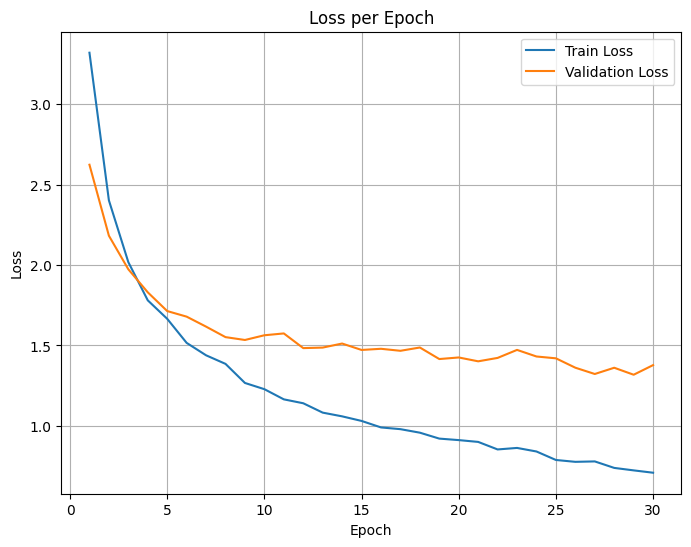

In [10]:
# 학습/검증 손실 변화를 그래프로 출력
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
%ls

best_model.pth           Flickr_8k.testImages.txt   models.py     test_folder/
captions.txt             Flickr_8k.trainImages.txt  __pycache__/  text_encoder.py
dataset.py               image_encoder.py           README.md     thoughts/
Flickr_8k.devImages.txt  images/                    runs/         train0313.ipynb
